## A-level: High-dimensional safety via discounted Safety Q-learning

In the previous sections, you implemented a grid-based HJ reachability solver and measured how runtime and memory explode with dimension $d$ (the curse of dimensionality). This extension explores a modern alternative: learning an approximate safety value function without discretizing the full state space.

Instead of a grid, we use a **Safety-specific Deep Q-Network (DQN)**. The goal is not to become an RL expert; we provide the training scaffold. Your focus is on:
- Designing the *safety margin* $l(x)$ for a 6D system.
- Implementing the *discounted safety backup* math from the literature.
- Probing how velocity "warps" the learned safe set.

We build on: Fisac et al., “Bridging Hamilton–Jacobi Safety Analysis and Reinforcement Learning” (ICRA 2019).

---

## Minimal RL background (what you need)

We assume a discrete-time system:
$$x_{t+1} = f(x_t, a_t)$$

where:
- $x_t \in \mathbb{R}^6$ is the state (position and velocity in 3D).
- $a_t$ is an action chosen from a finite set of discrete thrust vectors.

In standard Q-learning, we learn a function $Q(x,a)$ to maximize cumulative rewards. Here, we repurpose the architecture to learn the **Safety Value Function**.

---

## Safety margin $l(x)$

Define a scalar safety margin $l(x)$ such that:
- $l(x) > 0$: Safe (interior of the safe set).
- $l(x) = 0$: On the boundary.
- $l(x) < 0$: Safety violation.

For this assignment, your 6D state is $x = [p_x, p_y, p_z, v_x, v_y, v_z]$. While your geometric constraints might only depend on position, the **Value Function** you learn must account for velocity to ensure the robot can actually stop or turn in time.

---

## Discounted Safety Bellman backup (The "Plug-in" Math)

Fisac et al. propose a discounted operator that is a **contraction mapping**, enabling stable learning in high dimensions. The discounted safety Bellman equation is:

$$V(x) = (1-\gamma)\,l(x) + \gamma \min\Big(l(x),\; \max_{a} V(x')\Big)$$

In our implementation, you will provide a `safety_backup` function that computes the target values for the network update:

$$Q(x,a) \leftarrow (1-\gamma)l(x) + \gamma \min\Big(l(x),\; \max_{a'}Q(x',a')\Big)$$

Interpretation:
- $l(x)$ is the **current** safety margin.
- $\max_{a'}Q(x',a')$ is the predicted **future** safety from the next state under the best action.
- The $\min(\cdot)$ operator enforces the "worst margin over time" behavior.

---

## What you will implement (A-level)

You are given a `SafetyDQNAgent` and a `Dynamics6D` environment in `safety_rl_helper.py`. Your task is to implement the following functions and pass them to the training loop.

### Task A1: Design and implement $l(x)$
Implement `student_l_margin(states)`. You must define:
1. **A Box Constraint**: Stay within $p_{x,y,z} \in [-5, 5]$.
2. **An Obstacle Constraint**: Avoid a sphere at $[2, 2, 2]$ with radius $1.5$.

*Hint: Use `torch.min` to combine these; the system is only as safe as its most restrictive constraint.*

### Task A2: Implement the `safety_backup` function
Implement the function that calculates the targets for the DQN. This is the mathematical implementation of the equation shown above.

### Task A3: Probing the 6D Safe Set
Once trained, use the provided interactive slider to visualize 2D slices ($x$ vs. $y$) of your 6D safe set.
- Fix $z=0$ and $v_y, v_z = 0$.
- Use the slider to vary $v_x$ from $-3$ to $3$.
- **Observe**: How does the learned boundary (black) move relative to the true physical boundary (blue dashed) as you change velocity?

---

## Reflection questions

1. **Scalability vs. Guarantees**: Compare grid-based HJ reachability and learned safety Q-functions. What do we gain (scaling to 6D)? What do we lose (formal proof of safety)?
2. **The Velocity Shift**: When $v_x$ is high and positive, why does the "Safe Set" retreat away from the obstacle on the left side? Explain this using the concept of **stopping distance**.
3. **The `min` Operator**: In Task A2, what would happen if you removed the $\min(l(x), \dots)$ part of the backup and used a standard RL reward-summing approach?
4. **Constraint Learning Difficulty**: In your experiments, did the network learn the **box constraint** (flat boundaries) or the **spherical obstacle** (curved boundary) more accurately? Why might one be "easier" for a neural network to approximate than the other? 
5. **Validation**: Does $\hat V(x) > 0$ reliably predict "safe" rollouts? If the robot crashes even when $\hat V > 0$, is the model under-trained, or is $\gamma$ too low?

In [ ]:
import torch

# Task A1: Design l(x)
def student_l_margin(states):
    """
    Define the safety margin. Positive = Safe, Negative = Unsafe.
    Constraint: Keep |x,y,z| < 5 and avoid sphere at [2,2,2] with radius 1.5.
    """
    # TODO: Implement safety margin
    pass

# Task A2: Implement the Discounted Safety Bellman Backup
def safety_backup(target_net, s, s_next, l_margin_fn, gamma):
    """
    Implement Eq. 7 from Fisac et al. (2019):
    V(x) = (1-gamma)l(x) + gamma * min( l(x), max_a Q(s_next, a) )
    """
    # TODO: Implement the backup math
    pass

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from safety_rl_helper import SafetyDQNAgent, Dynamics6D

env = Dynamics6D()
agent = SafetyDQNAgent(state_dim=6, action_dim=env.action_dim, gamma=0.98)



print("Starting training...")
for ep in range(200):
    # Random start within the safe box
    state = np.random.uniform(-4, 4, size=6)
    total_loss = 0
    
    for t in range(200):
        action = agent.select_action(state, epsilon=0.2)
        next_state = env.step(state, action)
        agent.memory.append((state, action, next_state))
        
        loss = agent.compute_loss(safety_backup, student_l_margin)
        if loss: total_loss += loss
        state = next_state
        
    if ep % 10 == 0:
        agent.update_target_net()
        print(f"Episode {ep}, Avg Loss: {total_loss/50:.4f}")



Starting training...
Episode 0, Avg Loss: 0.0669
Episode 10, Avg Loss: 0.0614
Episode 20, Avg Loss: 0.0169
Episode 30, Avg Loss: 0.0144
Episode 40, Avg Loss: 0.0171
Episode 50, Avg Loss: 0.0227
Episode 60, Avg Loss: 0.0096
Episode 70, Avg Loss: 0.0117
Episode 80, Avg Loss: 0.0057
Episode 90, Avg Loss: 0.0120
Episode 100, Avg Loss: 0.0026
Episode 110, Avg Loss: 0.0023
Episode 120, Avg Loss: 0.0022
Episode 130, Avg Loss: 0.0027
Episode 140, Avg Loss: 0.0027
Episode 150, Avg Loss: 0.0019
Episode 160, Avg Loss: 0.0019
Episode 170, Avg Loss: 0.0015
Episode 180, Avg Loss: 0.0017
Episode 190, Avg Loss: 0.0090


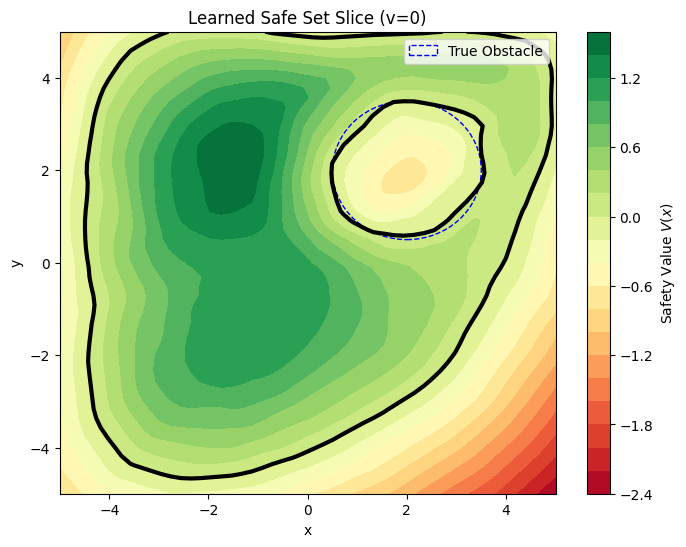

In [6]:
def plot_safe_set(agent, l_margin_fn, grid_res=50):
    # 1. Create a grid of x and y positions
    x_range = np.linspace(-5, 5, grid_res)
    y_range = np.linspace(-5, 5, grid_res)
    X, Y = np.meshgrid(x_range, y_range)
    
    # 2. Prepare states: [x, y, z=0, vx=0, vy=0, vz=0]
    # We fix the robot at z=0 and zero velocity to see the static safe set
    flat_X = X.flatten()
    flat_Y = Y.flatten()
    test_states = np.zeros((grid_res**2, 6))
    test_states[:, 0] = flat_X
    test_states[:, 1] = flat_Y
    test_states[:, 2] = 2
    
    # 3. Get Values from the Q-network
    states_t = torch.FloatTensor(test_states).to(agent.device)
    with torch.no_grad():
        # V(x) = max_a Q(x, a)
        values = agent.q_net(states_t).max(dim=1)[0].cpu().numpy()
    
    V_grid = values.reshape(grid_res, grid_res)
    
    # 4. Plotting
    plt.figure(figsize=(8, 6))
    
    # Plot the Value Function Heatmap
    cont = plt.contourf(X, Y, V_grid, levels=20, cmap='RdYlGn')
    plt.colorbar(cont, label="Safety Value $V(x)$")
    
    # Plot the Boundary (Zero-Level Set)
    plt.contour(X, Y, V_grid, levels=[0.0], colors='black', linewidths=3)
    
    # Plot the actual obstacle for comparison
    circle = plt.Circle((2, 2), 1.5, color='blue', fill=False, linestyle='--', label='True Obstacle')
    plt.gca().add_patch(circle)
    
    plt.title("Learned Safe Set Slice (v=0)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Run this after training
plot_safe_set(agent, student_l_margin)

In [7]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def interactive_safe_set(vx_value):
    grid_res = 70
    x_range = np.linspace(-6, 6, grid_res)
    y_range = np.linspace(-6, 6, grid_res)
    X, Y = np.meshgrid(x_range, y_range)
    
    # 1. Prepare states: [x, y, z=0, vx=val, vy=0, vz=0]
    test_states = np.zeros((grid_res**2, 6))
    test_states[:, 0] = X.flatten()
    test_states[:, 1] = Y.flatten()
    test_states[:, 3] = vx_value
    test_states[:, 2] = 2
    
    states_t = torch.FloatTensor(test_states).to(agent.device)
    
    with torch.no_grad():
        # 2. Get Predicted Safety Values (Learned)
        values = agent.q_net(states_t).max(dim=1)[0].cpu().numpy()
        V_grid = values.reshape(grid_res, grid_res)
        
        # 3. Get Ground Truth Safety Margin (from l_function)
        # This tells us where the obstacle physically is
        l_values = student_l_margin(states_t).cpu().numpy()
        L_grid = l_values.reshape(grid_res, grid_res)
    
    # 4. Plotting
    plt.figure(figsize=(9, 6))
    
    # The Heatmap of the LEARNED Value function
    cont = plt.contourf(X, Y, V_grid, levels=20, cmap='RdYlGn', alpha=0.7)
    plt.colorbar(cont, label="Learned Safety Value $\hat{V}(x)$")
    
    # The Learned 0-Level Set (The boundary the robot thinks is safe)
    cs_learned = plt.contour(X, Y, V_grid, levels=[0], colors='black', linewidths=3)
    
    # The GROUND TRUTH 0-Level Set (The boundary defined in Task A1)
    cs_truth = plt.contour(X, Y, L_grid, levels=[0], colors='blue', linestyles='--', linewidths=2)
    
    # Manual legend handling for contours
    h1, _ = cs_learned.legend_elements()
    h2, _ = cs_truth.legend_elements()
    plt.legend([h1[0], h2[0]], ["Learned Boundary ($\hat{V}=0$)", "True Boundary ($l(x)=0$)"])

    circle = plt.Circle((2, 2), 1.5, color='blue', fill=False, linestyle='--', label='True Obstacle')
    plt.gca().add_patch(circle)
    
    plt.title(f"Safe Set Slice at $v_x = {vx_value:.1f}$")
    plt.xlabel("x"); plt.ylabel("y")
    plt.grid(alpha=0.3)
    plt.show()

# Setup slider
vx_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.2, description='$v_x$ velocity:')
widgets.interactive(interactive_safe_set, vx_value=vx_slider)

interactive(children=(FloatSlider(value=0.0, description='$v_x$ velocity:', max=4.0, min=-4.0, step=0.2), Outp…